# Objekterkennung IntSys

In diesem Projekt sollen Objekte auf einem Drehteller mithilfe eines Ultraschall Sensors (HCSR04) erkannt werden.

Die gemessenen Daten befinden sich im Unterordner "messdaten"

### Primär orientieren wir uns an der digits-erkennen Übung, und benutzen sklearn

In [23]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.signal import wiener
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

plt.style.use("ggplot")




In [24]:
directory = "messdaten/"

dose_1 = "logfile_deo_dose_53mm.txt"
dose_2 = "logfile_dose_zweite_messung.txt"
dose_3 = "logfile_dose_dritte_messung.txt"
rubikscube_1 = "logfile_rubicscube_1.txt"
rubikscube_2 = "logfile_rubicscube_zweite_messung.txt"
jbl_1 = "logfile_jbl_speaker.txt"
prisma_1 = "logfile_prisma.txt"

noise = "logfile_empty.txt"

file_list = [
    dose_1,
    dose_2,
    dose_3,
    rubikscube_1,
    rubikscube_2,
    jbl_1,
    prisma_1]

df_noise = pd.read_csv(directory + noise, header=None)

df_list = []

for i in range(len(file_list)):
    temp_df = pd.read_csv(directory + file_list[i], header=None)
    df_list.append(temp_df)

# print(df_list)


In [25]:
def transform_data(df):
    """
    input 305 measurement points, > 5 turns * 61 measurements
    für jeden messpunkt einer drehung die nächsten 61 punkte anhängen
         > ACHTUNG!: nur wenn es 61 oder mehr messpunkte bis zum ende des input df gibt!

         > d.h. es gibt 305 - 61 = 244 output zeilen im df
    """
    # transpose from (n, 1) -> (1, n)
    df_transposed = df
    output_data = []

    for i in range(549): # 244 because 305 - 61 (letzte Umdrehung wird rausgenommen, damit jeder neue teil eine komplette umdrehung hat)
        one_turn = df_transposed.iloc[i:i+61, :]
        # print(one_turn)
        output_data.append(one_turn)
    dfs_reset_index = [df.reset_index(drop=True) for df in output_data]
    result_df = pd.concat(dfs_reset_index, axis=1)
    return result_df.T

In [26]:
def denoise(df_noisy, df_noise):
    noise_average_value = df_noise.mean().mean()
    df_shuffled_noise = df_noise.apply(np.random.permutation)
    df_denoised = df_noisy - df_shuffled_noise + noise_average_value
    return df_denoised

def smoothing(df):
    window_size = 8
    return df.rolling(window=window_size, min_periods=1).mean()


def fixed_threshold_filter(df):
    low_threshold, high_threshold = 0.1, 0.9

    for col in range(df.shape[1]):
        # Check if the current column's value is extreme
        if df.iloc[0, col] < low_threshold or df.iloc[0, col] > high_threshold:
            # Calculate the average of neighbors
            # Handle edge cases: If it's the first or last column, it only has one neighbor
            if col == 0:  # First column, only right neighbor available
                avg_neighbor = df.iloc[0, col + 1]
            elif col == df.shape[1] - 1:  # Last column, only left neighbor available
                avg_neighbor = df.iloc[0, col - 1]
            else:  # General case, average the left and right neighbor
                avg_neighbor = (df.iloc[0, col - 1] + df.iloc[0, col + 1]) / 2

            # Replace extreme value with the average of its neighbors
            df.iloc[0, col] = avg_neighbor

    return df

In [27]:
df_noise_transformed = transform_data(df_noise)
df_list_transformed = []

label_list = [
    "dose",
    "dose",
    "dose",
    "rubicscube",
    "rubicscube",
    "jbl_speaker",
    "prisma"
    ]

df_raw_list = []
df_denoised_list = []
df_remove_extreme_list = []

for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
    temp_df_remove_extreme = fixed_threshold_filter(temp_df_denoised)
    
    df_raw_list.append(temp_df_transformed)
    df_denoised_list.append(temp_df_denoised)
    df_remove_extreme_list.append(temp_df_remove_extreme)

    temp_df_remove_extreme['label'] = label_list[i]
    df_list_transformed.append(temp_df_remove_extreme)
    
df_for_training = pd.concat(df_list_transformed, axis=0)
df_for_training = df_for_training[['label'] + [col for col in df_for_training.columns if col != 'label']]

# print(df_for_training)

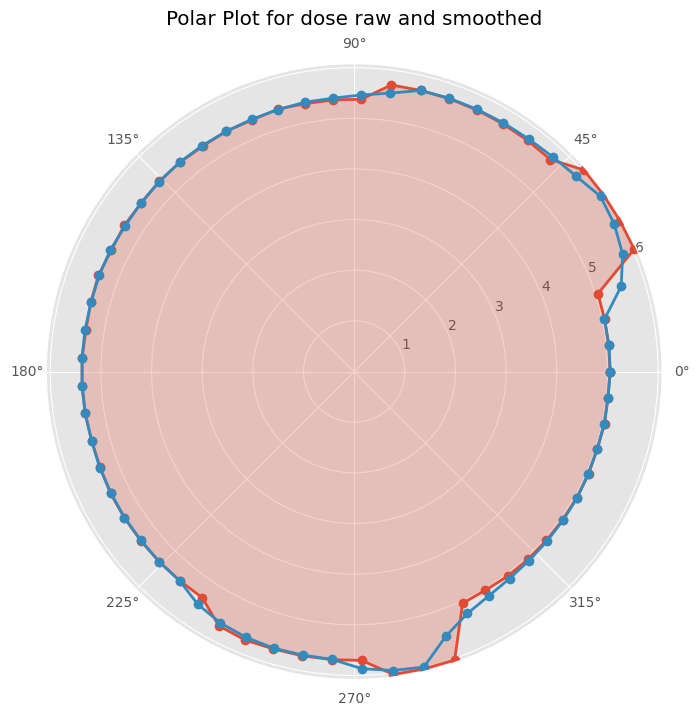

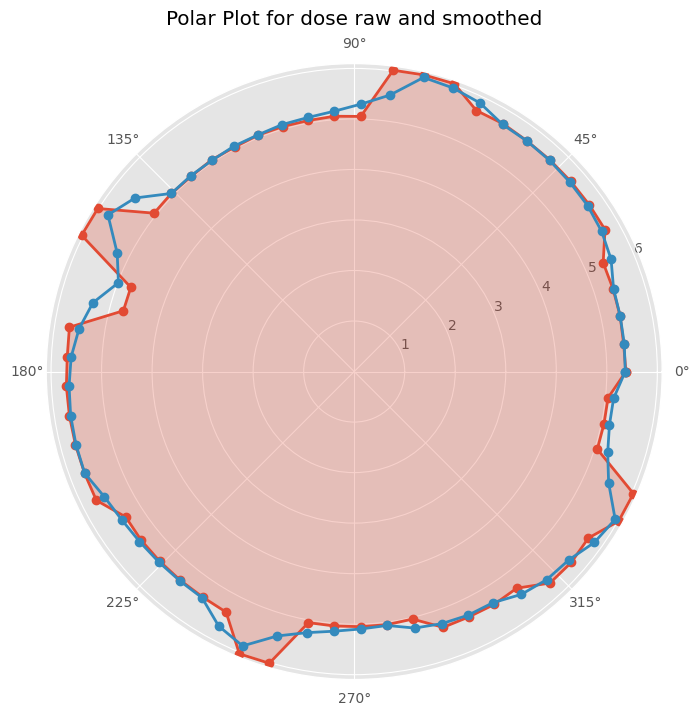

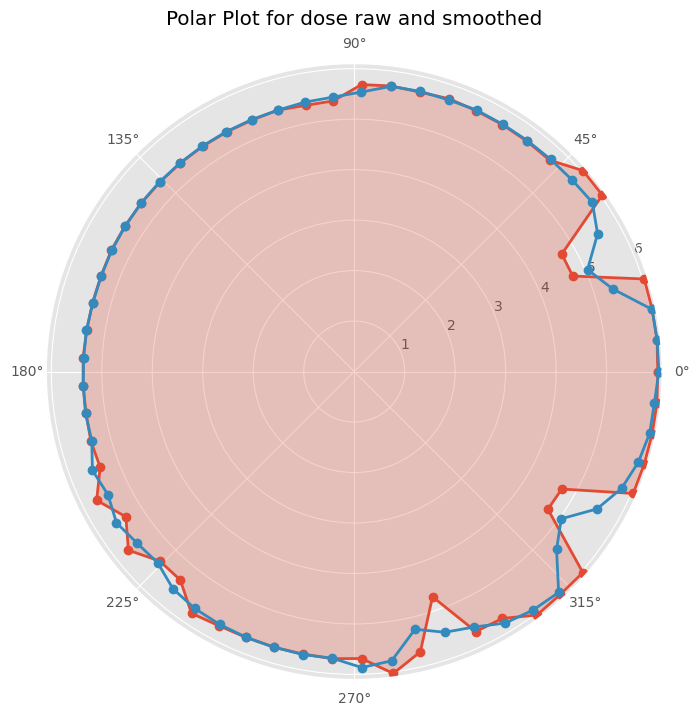

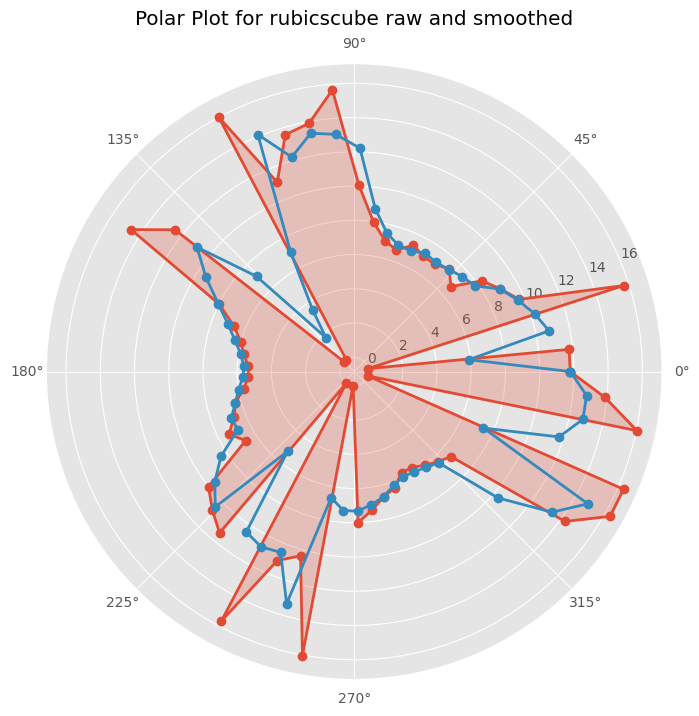

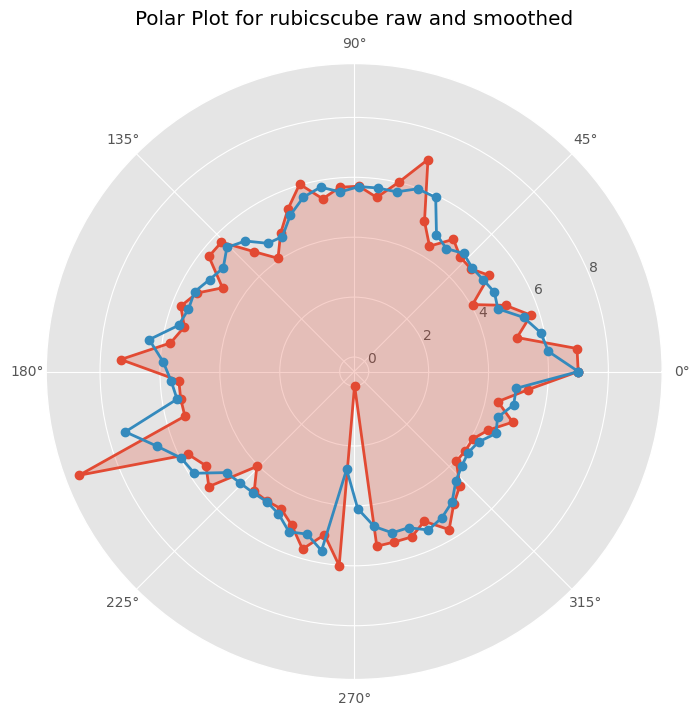

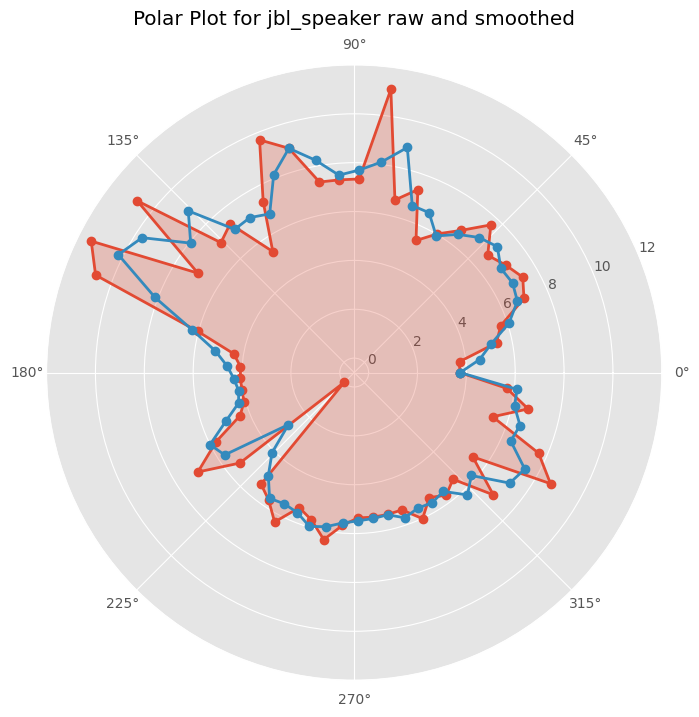

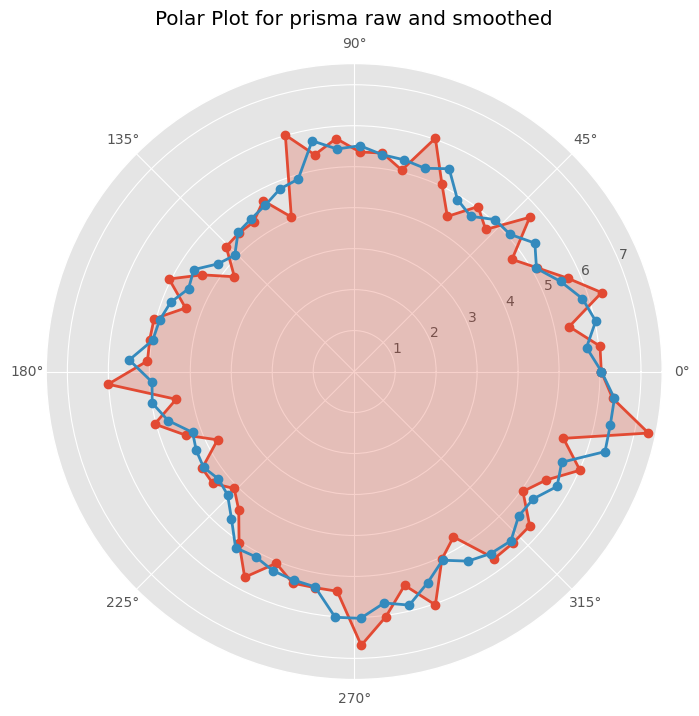

In [28]:


counter = 0
for i in range(len(df_list)):
    
    temp_df_raw = transform_data(df_raw_list[i])
    
    temp_df_filtered = df_remove_extreme_list[i].iloc[:, :-1]
    
    single_row_raw = temp_df_raw.iloc[0]
    single_row_filtered = temp_df_filtered.iloc[0]


    # Prepare the data for the polar plot
    angles = np.linspace(
        0, 2 * np.pi, 61, endpoint=False
    )  # Create 61 equally spaced angles
    angles = np.append(
        angles, angles[0]
    )  # Close the loop by appending the first angle at the end
    
    values_raw = single_row_raw.to_numpy()
    values_raw = np.append(
        values_raw, values_raw[0]
    )  # Close the loop by appending the first value at the end

    values_filtered = single_row_filtered.to_numpy()
    values_filtered = np.append(
        values_filtered, values_filtered[0]
    )

    # Create the polar plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values_raw.T, "o-", linewidth=2)  # Plot the values
    ax.fill(angles, values_raw.T, alpha=0.25)  # Fill the area under the curve
    
    ax.plot(angles, values_filtered.T, "o-", linewidth=2)  # Plot the values
    # ax.fill(angles, values_filtered.T, alpha=0.25)  # Fill the area under the curve
    
    plt.title(f"Polar Plot for {label_list[i]} raw and smoothed", va="bottom")
    plt.savefig(f"plots/{label_list[i]}_smooth_{counter}.png")
    plt.show()
    counter += 1

    pass



In [34]:
y = df_for_training['label']
X = df_for_training.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Anzahl der Ausgabeklassen
num_classes = len(label_encoder.classes_)

# Umwandlung der Labels in One-Hot-Encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [35]:
model = Sequential([
                    Dense(64, activation='relu', input_shape=(X_train.shape[1],),),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(num_classes, activation='softmax')  # anzahl der ausgabeneuronen entspricht anzahl der klassen
                    ])

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training des Modells
history = model.fit(X_train, y_train_categorical, epochs=125, batch_size=32, validation_data=(X_test, y_test_categorical))

#plotten von verlust und genauigkeitskurve

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochen = range(1, len(train_loss) +1)


Epoch 1/125
97/97 [==============================] - 1s 3ms/step - loss: 2.1736 - accuracy: 0.3826 - val_loss: 1.1201 - val_accuracy: 0.6658
Epoch 2/125
97/97 [==============================] - 0s 1ms/step - loss: 1.2141 - accuracy: 0.5621 - val_loss: 1.0212 - val_accuracy: 0.6645
Epoch 3/125
97/97 [==============================] - 0s 1ms/step - loss: 1.0751 - accuracy: 0.6142 - val_loss: 0.8856 - val_accuracy: 0.6840
Epoch 4/125
97/97 [==============================] - 0s 2ms/step - loss: 0.9992 - accuracy: 0.6392 - val_loss: 0.8155 - val_accuracy: 0.6944
Epoch 5/125
97/97 [==============================] - 0s 1ms/step - loss: 0.9141 - accuracy: 0.6509 - val_loss: 0.7334 - val_accuracy: 0.7204
Epoch 6/125
97/97 [==============================] - 0s 1ms/step - loss: 0.8263 - accuracy: 0.6724 - val_loss: 0.6554 - val_accuracy: 0.7256
Epoch 7/125
97/97 [==============================] - 0s 2ms/step - loss: 0.7867 - accuracy: 0.6698 - val_loss: 0.6324 - val_accuracy: 0.7308
Epoch 8/125
9

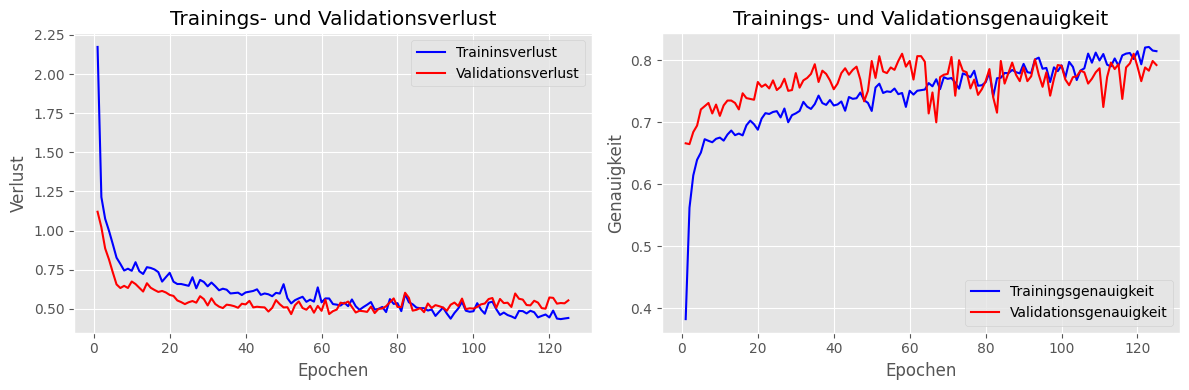

In [36]:
plt.figure(figsize=(12,4))


#verlust plot
plt.subplot(1, 2, 1)
plt.plot(epochen, train_loss, 'b-', label= "Traininsverlust")
plt.plot(epochen, validation_loss, 'r-', label= "Validationsverlust")
plt.title('Trainings- und Validationsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()


#genauigkeit plot
plt.subplot(1,2,2)
plt.plot(epochen, train_accuracy, 'b-', label= "Trainingsgenauigkeit")
plt.plot(epochen, validation_accuracy, 'r-', label= "Validationsgenauigkeit")
plt.title('Trainings- und Validationsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()


plt.tight_layout()
plt.show()

Trainingsgenauigkeit:  0.950227716330514


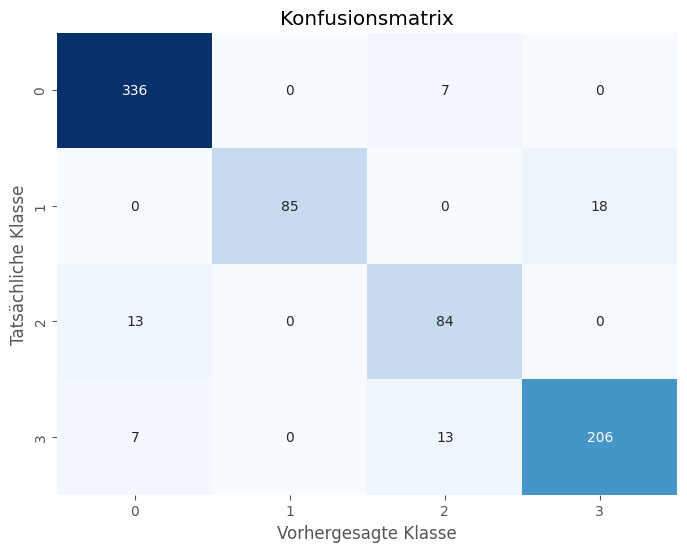

              precision    recall  f1-score   support

        dose       0.94      0.98      0.96       343
 jbl_speaker       1.00      0.83      0.90       103
      prisma       0.81      0.87      0.84        97
  rubicscube       0.92      0.91      0.92       226

    accuracy                           0.92       769
   macro avg       0.92      0.90      0.90       769
weighted avg       0.93      0.92      0.92       769



In [37]:


model = make_pipeline(StandardScaler(), SVC())

model.fit(X_train, y_train)

# Mache Vorhersagen auf den Trainingsdaten
y_train_pred = model.predict(X_train)

# Berechne die Trainingsgenauigkeit
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Trainingsgenauigkeit: ", train_accuracy)

# Mache Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
# plt.xticks(["dose", "jbl", "prisma", "rubicscube"])
# plt.yticks(["dose", "jbl", "prisma", "rubicscube"])
plt.show()

print(classification_report(y_test, y_pred))


In [38]:
model = SVC(probability=True)

# Then fit the model to your data
model.fit(X_train, y_train)


def make_prediction(new_measurement_preprocessed):
    # Assuming the model has already made a prediction
    predicted_category = model.predict(new_measurement_preprocessed)

    # When you only need the probability of the predicted class
    probabilities = model.predict_proba(new_measurement_preprocessed)
    # Get the index of the predicted class in the model's classes_
    class_index = list(model.classes_).index(predicted_category[0])
    # Use this index to access the corresponding probability
    predicted_prob = probabilities[0][class_index]
    return (predicted_category, predicted_prob)

neuen_daten = pd.read_csv(directory + dose_3, header=None)



# testing noise vs no noise vs filtered

unknown_measurement_list_raw = []
unknown_measurement_list_denoised = []
unknown_measurement_list_filtered = []


for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    unknown_measurement_list_raw.append(temp_df_transformed)
    
for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
    unknown_measurement_list_denoised.append(temp_df_denoised)
    
for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
    temp_df_filter = fixed_threshold_filter(temp_df_denoised)
    unknown_measurement_list_filtered.append(temp_df_filter)
    

print(50*"#")
for i in range(len(unknown_measurement_list_raw)):
    predicted_category, predicted_prob = make_prediction(unknown_measurement_list_raw[i])
    print(f"Predicted category: {predicted_category[0]} with confidence: {predicted_prob * 100:.2f}%")
    print(f"acutal object: {label_list[i]} raw")
print(50*"#")

for i in range(len(unknown_measurement_list_denoised)):
    predicted_category, predicted_prob = make_prediction(unknown_measurement_list_denoised[i])
    print(f"Predicted category: {predicted_category[0]} with confidence: {predicted_prob * 100:.2f}%")
    print(f"acutal object: {label_list[i]} denoised (?)")
print(50*"#")

for i in range(len(unknown_measurement_list_filtered)):
    predicted_category, predicted_prob = make_prediction(unknown_measurement_list_filtered[i])
    print(f"Predicted category: {predicted_category[0]} with confidence: {predicted_prob * 100:.2f}%")
    print(f"acutal object: {label_list[i]} filtered")
print(50*"#")


##################################################
Predicted category: dose with confidence: 99.86%
acutal object: dose raw
Predicted category: dose with confidence: 99.83%
acutal object: dose raw
Predicted category: dose with confidence: 99.44%
acutal object: dose raw
Predicted category: rubicscube with confidence: 82.98%
acutal object: rubicscube raw
Predicted category: prisma with confidence: 23.50%
acutal object: rubicscube raw
Predicted category: jbl_speaker with confidence: 99.25%
acutal object: jbl_speaker raw
Predicted category: prisma with confidence: 88.84%
acutal object: prisma raw
##################################################
Predicted category: dose with confidence: 99.85%
acutal object: dose denoised (?)
Predicted category: dose with confidence: 99.83%
acutal object: dose denoised (?)
Predicted category: dose with confidence: 99.45%
acutal object: dose denoised (?)
Predicted category: rubicscube with confidence: 83.03%
acutal object: rubicscube denoised (?)
Predicted